# Exploring Why Civil Resistance Works

Full Name: Michael Angeles

StudentId: 8200001

Email:t8200001@aueb.gr

## Assignment Overview

This assignment presents an intriguing exploration of the dynamics of civil resistance movements, primarily utilizing data-driven approaches. The core objective is to understand the factors that contribute to the success of these movements. To achieve this, we will delve into two comprehensive datasets: the Nonviolent and Violent Campaigns and Outcomes (NAVCO) 1.2 dataset, and the Polity5 dataset, which collectively offer a rich tapestry of historical campaign data and political context.

A significant portion of our analysis will center around the application of logistic regression models. These models are particularly suited for our purpose as they enable us to predict the probability of success of various campaigns based on a range of independent variables. By analyzing these probabilities, we can gain insights into the factors that most significantly impact the effectiveness of civil resistance.

Let us start by importing all the libraries we will be using in this assignment.

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch
import statsmodels.api as sm
import seaborn as sns
from scipy.special import expit

# Adjusting for better clarity
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

Now it's time to read the inital navco data and see what we are dealing with here: 

In [27]:
file_path = 'NAVCO 1.2 Updated.tab'

navco_data = pd.read_csv(file_path, delimiter='\t')
navco_data

,NAVCOID,CAMPAIGN,LOCATION,BYEAR,EYEAR,TARGET,SUCCESS,LIMITED,FAILURE,ONGOING,NONVIOL,VIOL,REGCHANGE,FSELFDET,SECESSION,OTHER,DURATION,PARTICIPATION,PERCENTAGEPOPULARPARTICIPATION,REGVIOL,DEFECT,VIOLENTFLANK,VIOLSIM,REGAID,STATESUP
0,4.0,Afghans,Afghanistan,1978.0,1979.0,Afghan government,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,613.0,10000.0,0.000641,1.0,1.0,NaN,1.0,1.0,1.0
1,3.0,Afghan resistance,Afghanistan,1980.0,1989.0,Soviet occupation,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,3281.0,10000.0,0.000685,1.0,0.0,NaN,1.0,0.0,1.0
2,218.0,Taliban/anti-government forces,Afghanistan,1992.0,1996.0,Afghan regime,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1370.0,20000.0,0.000893,1.0,0.0,NaN,1.0,0.0,0.0
3,217.0,Taliban,Afghanistan,2001.0,2014.0,Afghan government,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,4391.0,60000.0,0.001625,1.0,1.0,NaN,1.0,1.0,0.0
4,5.0,Albanian anti-communist,Albania,1990.0,1991.0,Communist regime,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,442.0,300000.0,0.091068,1.0,0.0,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
857,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
858,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
859,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
860,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Upon initial inspection of the NAVCO dataset, we identified a significant number of rows entirely comprised of missing values and observed that several columns, logically expected to be integers, were incorrectly formatted as floats. To address these issues, our `clean_navco_data` function systematically removes such rows and corrects the data types, thereby enhancing the dataset's accuracy and usability for analysis. Additionally, it introduces a 'Decade' column, which we will be using for our tasks below.

In [28]:
def clean_navco_data():
    
    file_path = 'NAVCO 1.2 Updated.tab'
    
    navco_data = pd.read_csv(file_path, delimiter='\t')
    
    # Drop rows where all values are NaN
    navco_data.dropna(how='all', inplace=True)
    
    # List of columns that should contain integer values
    int_columns = [
        'BYEAR', 'EYEAR', 'SUCCESS', 'LIMITED', 'FAILURE', 'ONGOING', 
        'NONVIOL', 'VIOL', 'REGCHANGE', 'FSELFDET', 'SECESSION', 'OTHER', 'PARTICIPATION'
    ]

    for col in int_columns:
        # Convert columns to integers, coercing NaNs to 0
        navco_data[col] = pd.to_numeric(navco_data[col], errors='coerce').fillna(0).astype(int)
    
    # Create the 'Decade' column
    navco_data['Decade'] = (navco_data['EYEAR'] // 10) * 10

    return navco_data

navco_data = clean_navco_data()
navco_data

,NAVCOID,CAMPAIGN,LOCATION,BYEAR,EYEAR,TARGET,SUCCESS,LIMITED,FAILURE,ONGOING,NONVIOL,VIOL,REGCHANGE,FSELFDET,SECESSION,OTHER,DURATION,PARTICIPATION,PERCENTAGEPOPULARPARTICIPATION,REGVIOL,DEFECT,VIOLENTFLANK,VIOLSIM,REGAID,STATESUP,Decade
0,4.0,Afghans,Afghanistan,1978,1979,Afghan government,1,0,0,0,0,1,1,0,0,0,613.0,10000,0.000641,1.0,1.0,NaN,1.0,1.0,1.0,1970
1,3.0,Afghan resistance,Afghanistan,1980,1989,Soviet occupation,1,0,0,0,0,1,0,1,0,0,3281.0,10000,0.000685,1.0,0.0,NaN,1.0,0.0,1.0,1980
2,218.0,Taliban/anti-government forces,Afghanistan,1992,1996,Afghan regime,1,0,0,0,0,1,1,0,0,0,1370.0,20000,0.000893,1.0,0.0,NaN,1.0,0.0,0.0,1990
3,217.0,Taliban,Afghanistan,2001,2014,Afghan government,0,0,1,1,0,1,1,0,0,0,4391.0,60000,0.001625,1.0,1.0,NaN,1.0,1.0,0.0,2010
4,5.0,Albanian anti-communist,Albania,1990,1991,Communist regime,1,0,0,0,1,0,1,0,0,0,442.0,300000,0.091068,1.0,0.0,0.0,1.0,1.0,0.0,1990
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
384,249.0,Zambian independence movement,Zambia,1961,1963,British rule,1,0,0,0,1,0,0,1,0,0,913.0,1000000,0.285063,0.0,1.0,0.0,0.0,0.0,0.0,1960
385,248.0,Zambia anti-single party rule,Zambia,1990,1991,One-party rule,1,0,0,0,1,0,1,0,0,0,488.0,23000,0.002791,1.0,0.0,0.0,1.0,0.0,0.0,1990
386,12.0,anti-Chiluba campaign,Zambia,2001,2001,Chiluba regime,1,0,0,0,1,0,1,0,0,0,213.0,3000,0.000277,0.0,0.0,0.0,0.0,0.0,0.0,2000
387,250.0,Zimbabwe African People's Union,Zimbabwe,1972,1979,Smith/Muzorena regime,0,1,0,0,0,1,1,0,0,0,2556.0,1000,0.000145,1.0,0.0,NaN,0.0,1.0,0.0,1970


Let's get a a closer look at some of the columns.
Understanding these attributes is crucial for any analysis that aims to uncover patterns and insights into the effectiveness of civil resistance campaigns.

* NAVCOID: A unique identifier for each campaign in the dataset. 

* CAMPAIGN: The name of the campaign.

* LOCATION: The geographical location where the campaign took place.

* BYEAR: The beginning year of the campaign. 

* EYEAR: The ending year of the campaign.

* TARGET: The primary target or entity against which the campaign was directed. 

* SUCCESS: Indicates whether the campaign was successful (1) or not (0). 

* LIMITED: Shows whether the campaign achieved limited success (1) or not (0).

* FAILURE: Marks campaigns that did not achieve their goals (1) or those that did (0).

* ONGOING: Identifies campaigns that were ongoing at the time of data recording (1) or those that had concluded (0).

* NONVIOL: Indicates whether the campaign was nonviolent (1) or not (0). 

* VIOL: Signifies whether the campaign was violent (1) or not (0). 

It's important to note that some of these columns come in logical pairs, where one is true (or 1), the other is false (or 0). 

For example:

NONVIOL and VIOL: A campaign is either nonviolent (NONVIOL = 1) or violent (VIOL = 1), but not both.

SUCCESS, LIMITED, FAILURE, ONGOING: These columns represent different outcomes of a campaign. A campaign can have only one of these statuses at a time, defining its overall result.

So let's investigate this.

The `check_nonviol_viol_status` function assesses the NAVCO dataset for campaigns that are either incorrectly marked as both nonviolent and violent or neither. It returns rows where the sum of `NONVIOL` and `VIOL` columns does not equal 1, indicating discrepancies in the classification of the campaign's nature.

In [29]:
def check_nonviol_viol_status(navco_data):
    invalid_nv_viol = navco_data[(navco_data['NONVIOL'] + navco_data['VIOL'] != 1)]
    return invalid_nv_viol

invalid_nv_viol = check_nonviol_viol_status(navco_data)
invalid_nv_viol

,NAVCOID,CAMPAIGN,LOCATION,BYEAR,EYEAR,TARGET,SUCCESS,LIMITED,FAILURE,ONGOING,NONVIOL,VIOL,REGCHANGE,FSELFDET,SECESSION,OTHER,DURATION,PARTICIPATION,PERCENTAGEPOPULARPARTICIPATION,REGVIOL,DEFECT,VIOLENTFLANK,VIOLSIM,REGAID,STATESUP,Decade


The result indicates no anomalies in the dataset regarding the nonviolence/violence status of campaigns – everything appears normal.

The `check_single_outcome_status` function inspects the NAVCO dataset to ensure that each campaign has a single, clear outcome status. It checks that the sum of the `SUCCESS`, `LIMITED`, `FAILURE`, and `ONGOING` columns equals 1 for each campaign, which would signify a well-defined outcome.

In [30]:
def check_single_outcome_status(navco_data):
    outcome_columns = ['SUCCESS', 'LIMITED', 'FAILURE', 'ONGOING']
    navco_data['outcome_sum'] = navco_data[outcome_columns].sum(axis=1)
    invalid_outcomes = navco_data[navco_data['outcome_sum'] != 1]
    return invalid_outcomes
    
invalid_outcomes = check_single_outcome_status(navco_data)
invalid_outcomes

,NAVCOID,CAMPAIGN,LOCATION,BYEAR,EYEAR,TARGET,SUCCESS,LIMITED,FAILURE,ONGOING,NONVIOL,VIOL,REGCHANGE,FSELFDET,SECESSION,OTHER,DURATION,PARTICIPATION,PERCENTAGEPOPULARPARTICIPATION,REGVIOL,DEFECT,VIOLENTFLANK,VIOLSIM,REGAID,STATESUP,Decade,outcome_sum
3,217.0,Taliban,Afghanistan,2001,2014,Afghan government,0,0,1,1,0,1,1,0,0,0,4391.0,60000,0.001625,1.0,1.0,NaN,1.0,1.0,0.0,2010,2
11,390.0,Cabinda Conflict,Angola,1991,2014,Govt of Angola,0,0,1,1,0,1,0,0,1,0,8263.0,1100,0.000039,1.0,0.0,NaN,NaN,0.0,1.0,2010,2
19,255.0,Anti-King Hamad Campaign,Bahrain,2011,2014,Monarchy of King Hamad,0,0,1,1,1,0,1,0,0,0,1050.0,100000,0.063816,1.0,0.0,1.0,0.0,0.0,0.0,2010,2
40,349.0,Naga Insurgency,Burma/Myanmar,1988,2014,Burmese and Indian rule,0,0,1,1,0,1,0,0,1,0,9848.0,2000,0.000037,1.0,0.0,NaN,1.0,0.0,0.0,2010,2
41,407.0,Myanmar Regime Change Campaign,Burma/Myanmar,1988,2014,Burmese government,0,0,1,1,0,1,1,0,0,0,9490.0,36000,0.000700,1.0,0.0,NaN,1.0,1.0,0.0,2010,2
54,404.0,Jama'atu Ahlis Sunna Lidda'awati wal-Jihad (Boko Haram Affliliate),Cameroon,2013,2014,Gov't of Cameroon,0,0,1,1,0,1,1,0,0,0,17.0,2001,0.000078,1.0,0.0,NaN,1.0,1.0,0.0,2010,2
72,182.0,"Revolutionary Armed Forces of Colombia, National Liberation Army, M-19",Colombia,1964,2014,Colombia govt and US influence,0,0,1,1,0,1,1,0,0,0,19046.0,12500,0.000257,1.0,1.0,NaN,1.0,0.0,0.0,2010,2
97,319.0,Sinai Insurgency,Egypt,2013,2014,Sisi Government,0,0,1,1,0,1,1,0,0,0,152.0,12000,0.000121,1.0,0.0,0.0,0.0,0.0,0.0,2010,2
105,382.0,Peoples’ Alliance for Freedom and Democracy,Ethiopia,1973,2014,Gov't of Ethiopia,0,0,1,1,0,1,0,1,0,0,16290.0,20000,0.000183,1.0,0.0,NaN,1.0,0.0,0.0,2010,2
139,144.0,Naga Rebellion,India,1951,2014,Indian occupation,0,0,1,1,0,1,0,0,1,0,22875.0,15000,0.000028,1.0,0.0,NaN,1.0,0.0,0.0,2010,2


Upon executing `check_single_outcome_status`, an interesting pattern emerges.
Some campaigns are simultaneously marked as `FAILURE` (1) and `ONGOING` (1). 
This could potentially be attributed to the dataset not being updated to reflect the final status of these campaigns. 
Such scenarios suggest that while these campaigns were initially considered failures, they might have continued beyond the point of data recording, necessitating a review or update of the dataset for current and accurate classification. For the purspose of this assignment, we will be leaving it as is, since we will not be using the `ONGOING` column in our tasks below.

## 1. Exploration of Historical Trends

The function `create_stacked_area_chart` visualizes the historical trend of nonviolent and violent campaigns over decades. 
It first ensures representation of all decades by creating a range, then groups the data by decade to sum violent and nonviolent campaign counts. 
Using a stackplot, it creates a stacked area chart and sets appropriate labels, titles, axis limits, and aesthetics before displaying the chart.

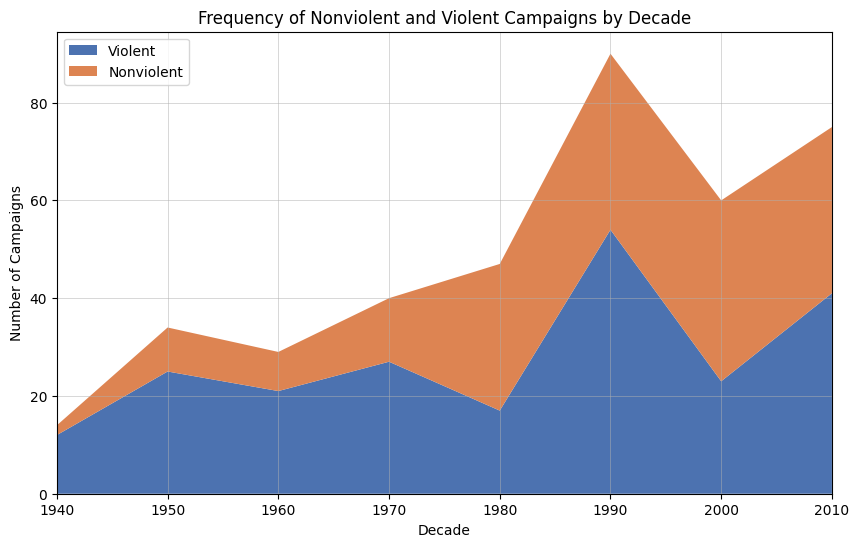

In [31]:
def create_stacked_area_chart(dataframe):
    # Make sure all decades are represented, even if some have zero campaigns
    all_decades = range(dataframe['Decade'].min(), dataframe['Decade'].max() + 10, 10)
    
    # Group by 'Decade' column and get the sum for the violent and nonviolent campaigns
    decade_data = dataframe.groupby('Decade').agg({'VIOL': 'sum', 'NONVIOL': 'sum'})
    decade_data = decade_data.reindex(all_decades, fill_value=0).reset_index()

    # Create the figure and axis objects
    fig, ax = plt.subplots(figsize=(10, 6))

    # Display the grid
    ax.grid(True, which='both', linestyle='-', linewidth=0.5, alpha=0.7)
    
    # Use stackplot to create the stacked area chart with the specified colors
    ax.stackplot(decade_data['Decade'], decade_data['VIOL'], decade_data['NONVIOL'], 
                 labels=['Violent', 'Nonviolent'], colors=['#4C72B0', '#DD8452'])

    # Set labels and title
    ax.set_xlabel('Decade')
    ax.set_ylabel('Number of Campaigns')
    ax.set_title('Frequency of Nonviolent and Violent Campaigns by Decade')
    ax.legend(loc='upper left')

    # Set the x-axis limits to avoid any gaps at the beginning
    ax.set_xlim(left=dataframe['Decade'].min(), right=dataframe['Decade'].max())

    # Show the plot
    plt.show()

# Call the function to create the plot
create_stacked_area_chart(navco_data)

The stacked area chart illustrates the evolving dynamics between nonviolent and violent campaigns from the 1940s to the 2010s:

* There is a visible dominance of violent campaigns until the 1970s, reflecting a period where armed struggle was a common method for political change, particularly in the context of decolonization and Cold War proxy conflicts.

* The 1980s demonstrate a marked increase in nonviolent campaigns, possibly as a result of global movements advocating for peace and civil rights, which gained prominence in the late 20th century.

* A dramatic shift occurs in the 1990s and 2000s, where nonviolent campaigns surge and surpass violent ones. This could be attributed to the global spread of democratic ideals and the effectiveness of nonviolent action as demonstrated by historical events like the fall of the Berlin Wall and the Velvet Revolutions in Eastern Europe.

* The chart encapsulates a historical transition towards nonviolent strategies in the modern era, suggesting a growing recognition of their effectiveness in achieving political and social objectives without resorting to violence.

The `plot_nonviolent_success_rate` function crafts a dual-axis bar chart that depicts the historical trend of nonviolent campaigns from the 1940s onward. It filters the dataset for nonviolent campaigns, calculates the total number per decade, and computes the success rate for each decade. The chart uses one vertical axis for the count of campaigns and a second for the success percentage, using different colors for clarity. This visualization provides a clear comparison of the prevalence and efficacy of nonviolent campaigns over time.

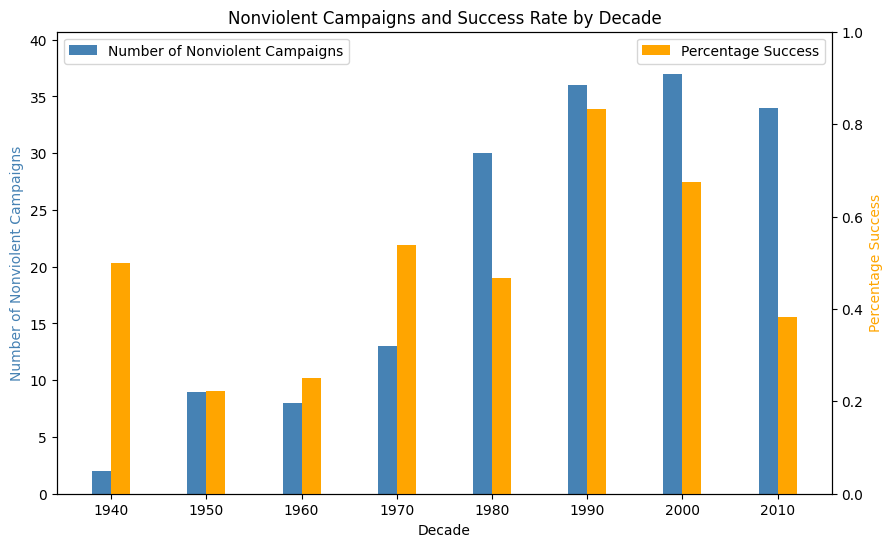

In [32]:
def plot_nonviolent_success_rate(dataframe):
    
    # Filter for nonviolent campaigns and campaigns from 1940s onwards 
    nonviolent_df = dataframe[(dataframe['NONVIOL'] == 1) & (dataframe['Decade'] >= 1940)]
    
    # Calculate the number of nonviolent campaigns per decade
    nonviolent_counts = nonviolent_df.groupby('Decade').size()
    
    # Calculate the success percentage for nonviolent campaigns per decade
    success_counts = nonviolent_df.groupby('Decade')['SUCCESS'].sum()
    success_percentage = success_counts / nonviolent_counts

    # Set up the figure and axis
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Set up the bar locations
    decades = nonviolent_counts.index
    bar_width = 0.2  # Skinnier bars
    index = np.arange(len(decades))

    # Plot bars for number of nonviolent campaigns
    bars1 = ax1.bar(index, nonviolent_counts, bar_width, label='Number of Nonviolent Campaigns', color='#4682B4')

    # Create another axis for the success percentage
    ax2 = ax1.twinx()
    bars2 = ax2.bar(index + bar_width, success_percentage, bar_width, label='Percentage Success', color='#FFA500')

    # Set the x-axis tick locations and labels
    ax1.set_xticks(index + bar_width / 2)
    ax1.set_xticklabels(decades)

    # Set the labels, title, and legend
    ax1.set_xlabel('Decade')
    ax1.set_ylabel('Number of Nonviolent Campaigns', color='#4682B4')
    ax2.set_ylabel('Percentage Success', color='#FFA500')
    ax1.set_title('Nonviolent Campaigns and Success Rate by Decade')
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')

    # Set y-axis limits
    ax1.set_ylim(0, nonviolent_counts.max() * 1.1)  # Add 10% headroom for visibility
    ax2.set_ylim(0, 1)  # Percentage scale from 0 to 1

    # Show the plot
    plt.show()


plot_nonviolent_success_rate(navco_data)

The bar chart presents a historical narrative of nonviolent campaigns and their outcomes by decade:

* Initially, the chart shows a gradual increase in nonviolent campaigns from the 1940s, reflecting the global rise in civil resistance movements post-World War II, as nations sought change through nonviolent means rather than through the conflict that had characterized the early 20th century.

* The significant rise in both the number and success rates in the 1980s may be attributed to the widespread democratization movements, particularly in Eastern Europe and Latin America, as well as the influence of global icons of nonviolence such as Martin Luther King Jr. and Mahatma Gandhi.

* The peak in success rates during the 2000s coincides with the proliferation of digital communication, which likely enhanced the coordination and impact of nonviolent campaigns, exemplified by movements such as the Arab Spring. This era marks the strategic refinement of nonviolent action, capitalizing on global connectivity and information dissemination.

The `plot_success_rate_by_decade` function generates a bar chart comparing the success rates of violent and nonviolent campaigns by decade. It groups the data by decade and campaign type, calculates the average success rate for each group, and displays the results in adjacent bars for direct comparison. The function employs clear labeling and color coding to differentiate between violent and nonviolent campaigns, facilitating an immediate visual interpretation of the trends.

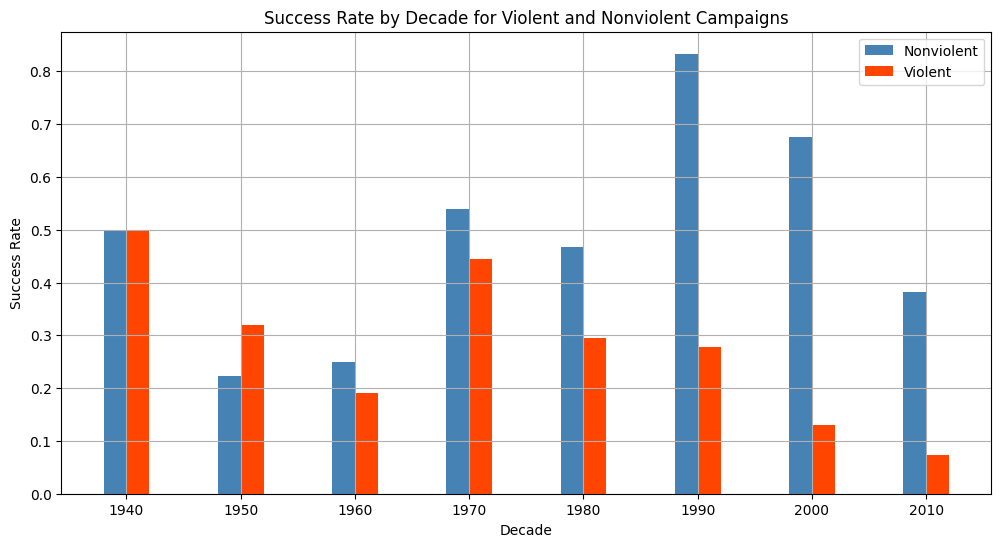

In [33]:
def plot_success_rate_by_decade(dataframe):
    # Calculate success rates
    success_data = dataframe.groupby(['Decade', 'NONVIOL'])['SUCCESS'].mean().unstack()
    success_data.columns = ['violent', 'nonviolent']

    # Set up the figure and axis
    fig, ax = plt.subplots(figsize=(12, 6))

    # Set up the bar locations with a smaller width
    bar_width = 0.2  # Reduced bar width for skinnier bars
    index = np.arange(len(success_data))

    # Plot bars for success rates
    bars1 = ax.bar(index - bar_width/2, success_data['nonviolent'], bar_width, label='Nonviolent', color='#4682B4')
    bars2 = ax.bar(index + bar_width/2, success_data['violent'], bar_width, label='Violent', color='#FF4500')

    # Set the x-axis tick locations and labels
    ax.set_xticks(index)
    ax.set_xticklabels(success_data.index.astype(str))
    ax.set_xlabel('Decade')
    ax.set_ylabel('Success Rate')
    ax.set_title('Success Rate by Decade for Violent and Nonviolent Campaigns')
    ax.legend()

    # Show the grid behind the plots
    ax.grid(True)

    # Show the plot
    plt.show()

# Call the function to create the plot
plot_success_rate_by_decade(navco_data)

The bar chart presents a comparative analysis of the success rates for violent and nonviolent campaigns by decade:

* The data shows that nonviolent campaigns outperform violent ones in achieving their goals throughout the surveyed period, underscoring the strategic advantage of nonviolent methods in diverse political and social contexts.

* The surge in the success of nonviolent campaigns during the 1990s correlates with the end of the Cold War and the emergence of a new world order, where civil society could leverage global platforms and media to gain international support and legitimacy.

* The fluctuating success rate of violent campaigns, with a downturn in the most recent decade, might reflect an evolving global consensus against the use of violence, as well as improvements in conflict resolution mechanisms and international diplomacy.

* The trends observed in the chart are reflective of a broader historical shift towards nonviolent resistance as a preferred mode of effecting change, especially in a post-Cold War era characterized by a growing emphasis on human rights and democratic governance.

# 2. Largest Resistance Campaigns, 1946-2014

The `plot_resistance_campaigns` function generates a horizontal bar plot representing resistance campaigns with participation of at least 2.0%. The plot categorizes campaigns by outcome using color coding—black for success, grey for major concessions, and red for failure. 
It sorts the campaigns in ascending order by participation percentage and adds a label to each bar for identification. Legends are included for clarity, and the plot is adjusted for optimal layout.

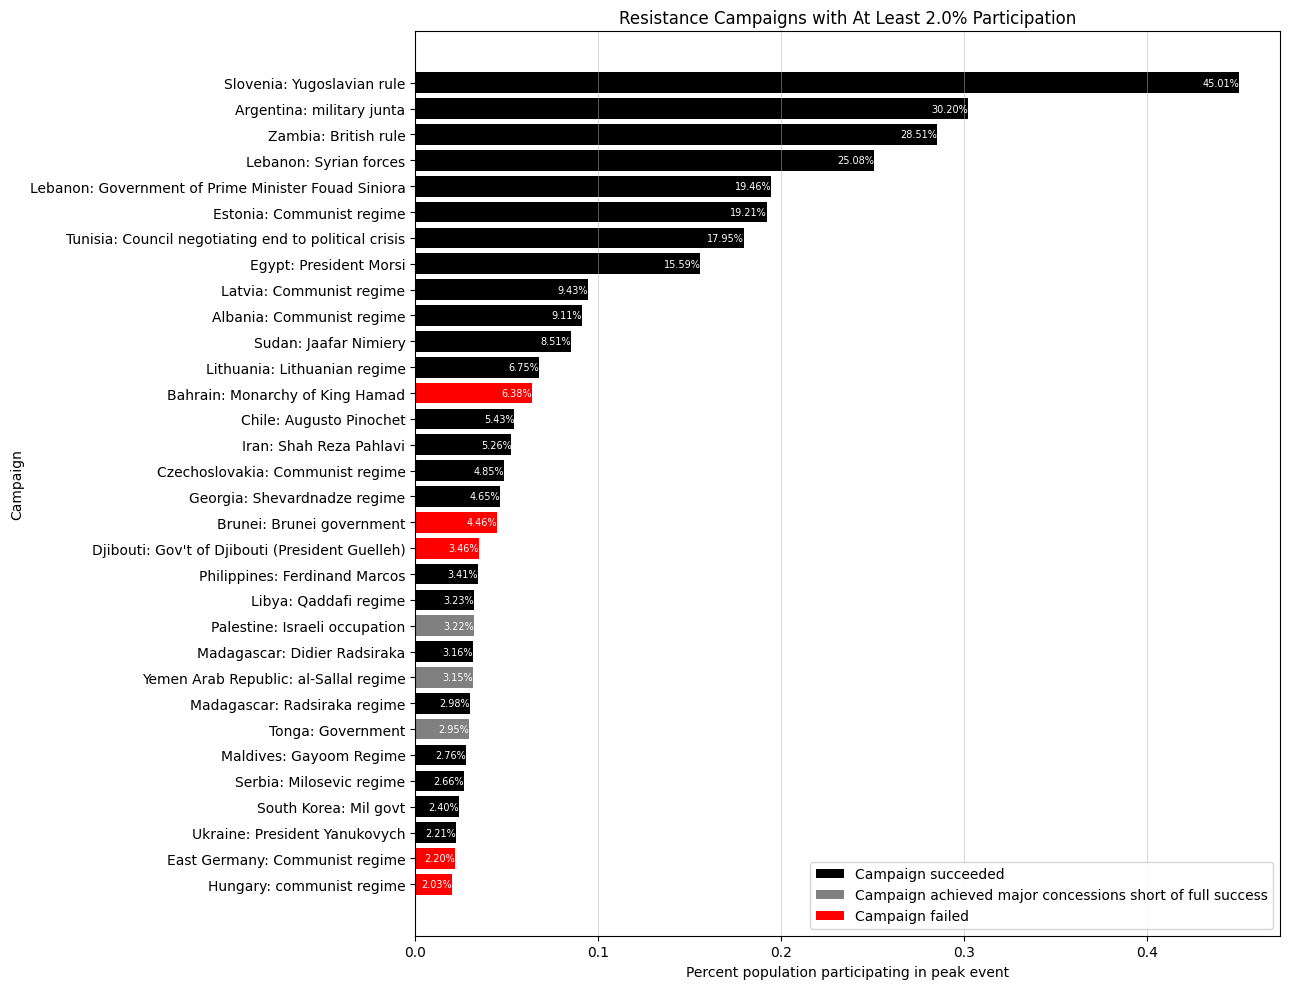

In [34]:
def plot_resistance_campaigns(dataframe, participation_threshold=0.02):
    
    # Filter campaigns with at least 2.0% participation
    filtered_df = dataframe[dataframe['PERCENTAGEPOPULARPARTICIPATION'] >= participation_threshold].copy()
    
    # Prepare the color mapping based on campaign outcome
    conditions = [
        filtered_df['SUCCESS'] == 1,
        filtered_df['LIMITED'] == 1,
        filtered_df['FAILURE'] == 1
    ]
    # Define the color for each condition
    colors = ['black', 'grey', 'red']  # success, major concessions, failed
    filtered_df['color'] = np.select(conditions, colors)
    
    # Sort campaigns for plotting
    filtered_df = filtered_df.sort_values('PERCENTAGEPOPULARPARTICIPATION', ascending=True)
    
    # Create the label for each bar
    filtered_df['bar_label'] = filtered_df['LOCATION'] + ": " + filtered_df['TARGET']
    
    # Create the horizontal bar plot
    plt.figure(figsize=(13, 10))
    bar_plot = plt.barh(filtered_df['bar_label'], filtered_df['PERCENTAGEPOPULARPARTICIPATION'], color=filtered_df['color'])

    # Add the percentages at the end of each bar
    for bar, percentage in zip(bar_plot, filtered_df['PERCENTAGEPOPULARPARTICIPATION']):
        plt.text(
            bar.get_width(),  # Position at the end of the bar
            bar.get_y() + bar.get_height()/2,  # Position at the center of the bar height
            f'{percentage:.2%}',  # Format to percentage with 2 decimals
            va='center', ha='right', color='white', fontsize=7
        )

    # Add labels and title
    plt.xlabel('Percent population participating in peak event')
    plt.ylabel('Campaign')
    plt.title('Resistance Campaigns with At Least 2.0% Participation')

    # Create custom legends
    legend_elements = [
        Patch(facecolor='black', label='Campaign succeeded'),
        Patch(facecolor='grey', label='Campaign achieved major concessions short of full success'),
        Patch(facecolor='red', label='Campaign failed')
    ]
    plt.legend(handles=legend_elements, loc='lower right')

    # Show the grid behind the plots
    plt.grid(True, axis='x', linestyle='-', linewidth=0.5, alpha=0.7)

    # Show the plot
    plt.tight_layout()  # Adjust layout to fit everything nicely
    plt.show()


plot_resistance_campaigns(navco_data)

The horizontal bar plot provides a clear visualization of the scale of participation in resistance campaigns from 1946 to 2014:

* Campaigns with the highest participation rates, notably those around 10% and increasing, tend to have achieved success, illustrated by the prevalence of black bars in these ranges.

* The plot shows that larger scale participation does not always guarantee success, as indicated by several red bars, but there is a tendency for higher participation to correlate with more favorable outcomes.

* The data could suggest that widespread public involvement may put significant pressure on political systems, potentially leading to concessions or changes, although other factors clearly also play a role in determining the success of such campaigns.

Yet Greece, our beloved country is nowhere to be found in this chart, but we can filter based on the location and see what comes up.

In [35]:
greece_navco = navco_data[navco_data['LOCATION'] == 'Greece']
greece_navco

,NAVCOID,CAMPAIGN,LOCATION,BYEAR,EYEAR,TARGET,SUCCESS,LIMITED,FAILURE,ONGOING,NONVIOL,VIOL,REGCHANGE,FSELFDET,SECESSION,OTHER,DURATION,PARTICIPATION,PERCENTAGEPOPULARPARTICIPATION,REGVIOL,DEFECT,VIOLENTFLANK,VIOLSIM,REGAID,STATESUP,Decade,outcome_sum
119,401.0,Greek Civil War,Greece,1946,1949,British and US occupation,0,0,1,0,0,1,0,1,0,0,1778.0,40000,0.005092,1.0,0.0,NaN,0.0,1.0,1.0,1940,1
120,89.0,Greek anti-military,Greece,1973,1974,Military rule,1,0,0,0,1,0,1,0,0,0,654.0,2500,0.000279,1.0,1.0,1.0,0.0,1.0,0.0,1970,1


**Greek Civil War (1946-1949)**
The Greek Civil War was a conflict that arose in the aftermath of World War II, as a struggle between the government (backed by British and US forces) and communist rebels. The campaign aimed at resisting foreign occupation and establishing a communist government. Despite significant participation, it was marked as a failure and concluded with the establishment of Greece as a capitalist state.

**Greek Anti-Military Protests (1973-1974)**
The Greek anti-military protests were a series of nonviolent demonstrations against the military junta that ruled Greece from 1967 to 1974. The movement, which included a significant student component, played a critical role in restoring democracy in Greece. It is marked as a successful campaign that contributed to the collapse of military rule and the re-establishment of democratic governance.

## 3. The Effect of Participation on the Probability of Campaign Success

In this analysis, we aim to quantify the impact of participation per capita on the likelihood of success in resistance campaigns. Logistic regression will be used, with the participation per capita and the logged population of the campaign's location serving as independent variables, and the probability of campaign success as the dependent variable. This statistical approach allows us to assess the influence of public engagement while considering the size of the population where the campaign occurred.

The preprocessing script prepares the data for logistic regression by calculating the participation per capita, a variable not directly available in the dataset. Participation per capita is the log ratio of campaign participants to the overall population. Since we don't have explicit population figures, we estimate it by inverting the percentage of popular participation. 

The formula for membership per capita is:

$$
\text{Membership Per Capita} = \frac{\log(\text{Participation})}{\log(\text{Population})}
$$

Here, population is derived as:

$$
\text{Population} = \frac{\text{Participation}}{\text{Percentage of Popular Participation}}
$$
​
This script ensures positive values before applying the logarithm and constructs a binary success variable for the regression.
The column name `logged_participants_per_capita` is considered the participation per capita

In [36]:
def preprocess_data(navco_data):
    # Create a copy of the dataframe to avoid modifying the original dataframe
    data = navco_data.copy()

    # Calculate the population from the participation and percentage of popular participation
    # Handle division by zero or very small values
    data['population'] = data['PARTICIPATION'] / (data['PERCENTAGEPOPULARPARTICIPATION'].replace(0, np.nan))
    
    # Make sure there are no zero or negative values before log transformation
    data = data[(data['population'] > 0) & (data['PARTICIPATION'] > 0)]
    
    # Calculate the logged ratio of participants to population
    data['logged_participants_per_capita'] = np.log(data['PARTICIPATION']) / np.log(data['population'])

    data['logged_population'] = np.log(data['population'])
    
    # Define 'SUCCESS' as a binary variable, maybe considering 'LIMITED' as success if needed
    # data['SUCCESS_BINARY'] = data['SUCCESS'].fillna(0).astype(int) | data['LIMITED'].fillna(0).astype(int)
    
    # Ensure SUCCESS column is not NaN before conversion to int
    data['SUCCESS_BINARY'] = data['SUCCESS'].fillna(0).astype(int)
    
    # Drop rows with missing values in the necessary columns
    data.dropna(subset=['SUCCESS_BINARY', 'logged_participants_per_capita', 'population'], inplace=True)
    
    return data
 
data_processed = preprocess_data(navco_data)

The `train_model` function takes the processed data and fits a logistic regression model using `logged_participants_per_capita` and `logged_population` as predictors. It adds a constant term for the intercept, fits the model to the binary success outcome, and returns a summary of the regression results. This model will enable us to predict the likelihood of campaign success based on the level of public engagement relative to population size, while accounting for the scale of the population.

This function will also be used in other logistic regression since we also take as isnput the columns for independent variables. 

In [37]:
def train_model(data_processed, x_columns):
    # Prepare the feature and target for logistic regression
    X = data_processed[x_columns]
    
    # Adds a constant term to the predictor
    X = sm.add_constant(X)  
    
    y = data_processed['SUCCESS_BINARY']
    
    # Fit the logistic regression model
    logit_model = sm.Logit(y, X)
    result = logit_model.fit()
    
    return result

x_columns = ['logged_participants_per_capita', 'logged_population']
logistic_regression_result = train_model(data_processed, x_columns)
logistic_regression_result.summary()

Optimization terminated successfully.
         Current function value: 0.580756
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:         SUCCESS_BINARY   No. Observations:                  380
Model:                          Logit   Df Residuals:                      377
Method:                           MLE   Df Model:                            2
Date:                Mon, 04 Dec 2023   Pseudo R-squ.:                  0.1297
Time:                        22:14:06   Log-Likelihood:                -220.69
converged:                       True   LL-Null:                       -253.58
Covariance Type:            nonrobust   LLR p-value:                 5.189e-15
==================================================================================================
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                             -2.8142      1.496     -1.881      0.060      -5.746       0.118
logged_participants_per_capita     7.6475      1.166      6.556      0.000       5.361       9.934
logged_population                 -0.1388      0.074     -1.887      0.059      -0.283       0.005
==================================================================================================
"""

<span style="font-size:20px;"><strong>Description Summary</strong></span>


* **Pseudo R-squared (0.1297)**: A value of 0.1297 shows the proportion of variance in the dependent variable that's predictable from the independent variables. While different from R-squared in linear regression, a higher value here still indicates better explanatory power.

* **logged_participants_per_capita (7.6475; p<0.001)**: The coefficient of 7.6475 is substantial and positively influences the success probability. The associated p-value of 0.000 indicates a strong, statistically significant relationship.

* **logged_population (-0.1388; p=0.059)**: With a coefficient of -0.1388, the logged population size seems to have a slight negative impact on the probability of success, though with a p-value of 0.059, this is only marginally significant.

The `plot_final_probabilities` function visualizes the relationship between participants per capita and the predicted probability of campaign success. It first adds a constant to the predictors, uses the logistic regression results to predict success probabilities, and then creates a scatter plot. 

The plot displays each campaign as a point, with the x-axis showing logged participants per capita and the y-axis the probability of success. The function sets the y-axis limits from 0 to 1 to reflect the probability scale and includes a grid for better readability.

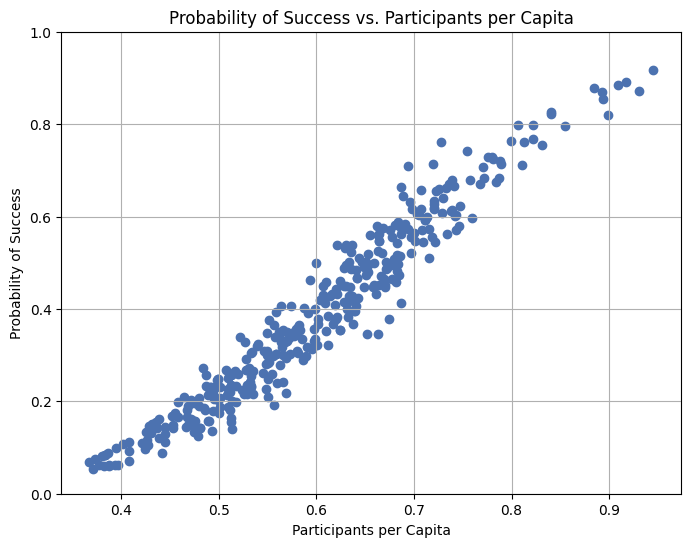

In [38]:
def plot_final_probabilities(data_processed, logistic_regression_result):
    data_processed = data_processed.copy()
    
    X = sm.add_constant(data_processed[['logged_participants_per_capita', 'logged_population']])

    # Use the model to predict probabilities
    probabilities_succeeding = logistic_regression_result.predict(X)

    # Create the scatter plot with matplotlib defaults for styling
    plt.figure(figsize=(8, 6))
    plt.scatter(data_processed['logged_participants_per_capita'], probabilities_succeeding, color='#4c72b0', marker='o')
    plt.xlabel('Participants per Capita')
    plt.ylabel('Probability of Success')
    plt.title('Probability of Success vs. Participants per Capita')
    plt.grid(True)
    
    # Adjust y-axis to match the scale of the probabilities
    plt.ylim(0, 1)
    
    plt.show()

# Call the function to plot the probabilities
plot_final_probabilities(data_processed, logistic_regression_result)

The scatter plot illustrates a positive correlation between participants per capita and the probability of campaign success:

* As the logged ratio of participants per capita increases, there's a visible trend of higher success probabilities for campaigns.

* This trend highlights the potential influence of greater public participation on the likelihood of a campaign's success.

* The initial scatter plot's wide spread indicates that factors beyond participants per capita contribute to campaign success, a variance that is streamlined when this metric is the sole predictor, as seen in the subsequent, more concise plot.

Now we will run the logistic regression, but this time only controlling the `logged_participants_per_capita` as an independent variable.
Let's see what we get.

In [39]:
x_columns = ['logged_participants_per_capita']
logistic_regression_result = train_model(data_processed, x_columns)
logistic_regression_result.summary()

Optimization terminated successfully.
         Current function value: 0.585556
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:         SUCCESS_BINARY   No. Observations:                  380
Model:                          Logit   Df Residuals:                      378
Method:                           MLE   Df Model:                            1
Date:                Mon, 04 Dec 2023   Pseudo R-squ.:                  0.1225
Time:                        22:14:06   Log-Likelihood:                -222.51
converged:                       True   LL-Null:                       -253.58
Covariance Type:            nonrobust   LLR p-value:                 3.204e-15
==================================================================================================
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                             -5.3469      0.709     -7.536      0.000      -6.737      -3.956
logged_participants_per_capita     8.0495      1.141      7.052      0.000       5.812      10.287
==================================================================================================
"""

<span style="font-size:20px;"><strong>Description Summary</strong></span>

* **Pseudo R-squ.(0.1225)**: With a value of 0.1225, the model explains approximately 12.25% of the variance in the success of campaigns, which suggests a meaningful but not exhaustive relationship.

* **logged_participants_per_capita (8.0495; p<0.001)**: The coefficient of 8.0495 indicates a strong positive relationship between participants per capita and the success of a campaign. The p-value of 0.000 demonstrates this relationship is statistically significant.

* **Constant (-5.3469)**: The negative constant of -5.3469 suggests that when the participants per capita is zero, the log odds of success are significantly below zero, but the interpretation of the intercept in logistic regression is often not meaningful without context.

The `plot_participation_vs_success` function plots the predicted probabilities of campaign success against the participants per capita. It adds a constant to the predictor, computes the success probabilities using the logistic regression model, and then creates a scatter plot. 

The plot provides a visual representation of the probability of success as the participation increases, with the x-axis representing  participants per capita and the y-axis the model's estimated probability of success.

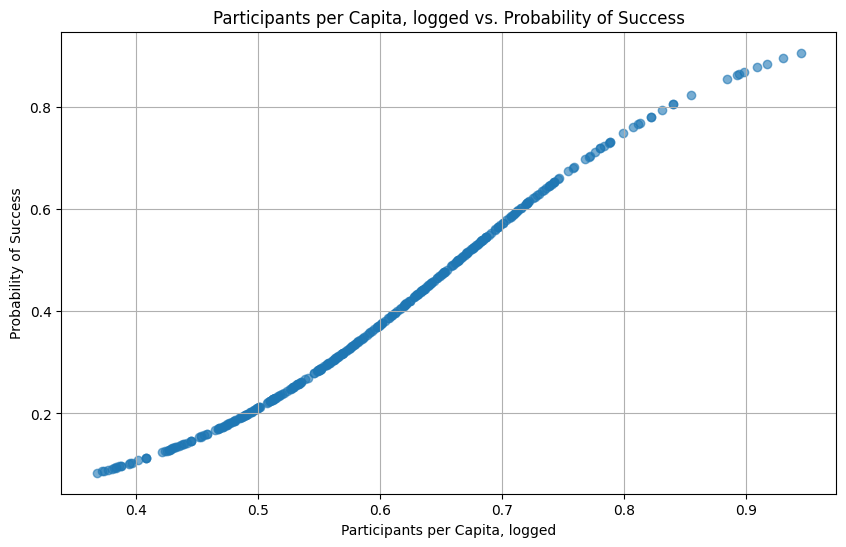

In [40]:
def plot_participation_vs_success(data_processed):
    # Calculate the probability of success from the model
    X = sm.add_constant(data_processed['logged_participants_per_capita'])
    probabilities = logistic_regression_result.predict(X)
    
    # Create scatter plot
    plt.figure(figsize=(10, 6))
    plt.scatter(data_processed['logged_participants_per_capita'], probabilities, alpha=0.6)
    plt.title('Participants per Capita, logged vs. Probability of Success')
    plt.xlabel('Participants per Capita, logged')
    plt.ylabel('Probability of Success')
    plt.grid(True)
    plt.show()

plot_participation_vs_success(data_processed)

The scatter plot demonstrates a much tighter correlation participants per capita and the probability of success, compared to the previous plot. This suggests that by focusing solely on the participants per capita as an independent variable, we've removed other contributing noise, resulting in a clearer relationship. The trend line through the scatter plot shows a positive correlation, indicating that as participation increases, so does the probability of a campaign's success.

## 4. The Level of Participation Tipping Point

Erica Chenoweth's 3.5% rule, which posits that no government can withstand a campaign that mobilizes more than 3.5% of its population, emerges from a rigorous analysis of historical data. The rule is substantiated by the NAVCO dataset, where campaigns exceeding this threshold universally succeeded. 
The `calculate_success_rate_by_participation` function mirrors this analysis: 

* it segments the data into participation ranges
* calculates success rates
* validates the empirical observation that campaigns with participation above 3.5% have invariably led to success.

This statistical evidence from the dataset robustly supports the 3.5% rule posited by Chenoweth.

In [41]:
def calculate_success_rate_by_participation(data):
    # Define the participation ranges
    participation_ranges = {
        'greater than 3.5%': (3.5, float('inf')),
        '1.0% - 3.5%': (1.0, 3.5),
        '0.25% - 1.0%': (0.25, 1.0),
        '0.06% - 0.25%': (0.06, 0.25),
        '0.015% - 0.06%': (0.015, 0.06),
        '0.0035% - 0.015%': (0.0035, 0.015),
        'less than 0.0035%': (0, 0.0035)
    }

    # Convert participation percentage to proportion
    data['PERCENTAGEPOPULARPARTICIPATION'] *= 100

    # Categorize each campaign
    def categorize_participation(percentage):
        for category, (lower, upper) in participation_ranges.items():
            if lower <= percentage <= upper:
                return category
        return 'Unknown'

    data['Participation_Category'] = data['PERCENTAGEPOPULARPARTICIPATION'].apply(categorize_participation)

    # Calculate success rate for each category
    success_rate_table = data.groupby('Participation_Category').agg(
        Observations=('SUCCESS', 'count'),
        Successes=('SUCCESS', 'sum')
    ).sort_values(by='Observations', ascending=False)
    success_rate_table['Success Rate (%)'] = (success_rate_table['Successes'] / success_rate_table['Observations']) * 100

    # Round success rate to 2 decimal places, convert observations to int, and format success rate as percentage
    success_rate_table['Success Rate (%)'] = success_rate_table['Success Rate (%)'].round(2).astype(str) + '%'
    success_rate_table['Observations'] = success_rate_table['Observations'].astype(int)

    # Reorder and format the table
    success_rate_table = success_rate_table.reindex(list(participation_ranges.keys()) + ['Unknown'])
    success_rate_table.drop('Unknown', inplace=True)  # Remove 'Unknown' category
    success_rate_table.reset_index(inplace=True)
    success_rate_table.rename(columns={'Participation_Category': 'Peak Popular Participation (%)'}, inplace=True)

    return success_rate_table[['Peak Popular Participation (%)', 'Observations', 'Success Rate (%)']]


success_rate_table = calculate_success_rate_by_participation(data_processed)
success_rate_table

,Peak Popular Participation (%),Observations,Success Rate (%)
0,greater than 3.5%,18.0,88.89%
1,1.0% - 3.5%,41.0,60.98%
2,0.25% - 1.0%,92.0,45.65%
3,0.06% - 0.25%,95.0,45.26%
4,0.015% - 0.06%,66.0,24.24%
5,0.0035% - 0.015%,44.0,9.09%
6,less than 0.0035%,24.0,4.17%


In our journey to uncover the tipping point of participation for a 99% probability of campaign success, we confronted a challenge: 

The predicted probabilities from our logistic regression didn't naturally extend to such a high level of certainty. To address this, we honed in on a logistic regression model with a singular focus—`logged_participants_per_capita`. This model strips away the complexity introduced by other variables, like `logged_population`, which our initial model included. We found this simpler model to be more telling for our specific query, as it zeroes in, on the direct impact of participation on success.

The solution to our conundrum lay in the confidence intervals derived from this streamlined model. These intervals stretch beyond the observed data, into the realm of what could be—particularly the optimistic upper bound. It's here we find our answer. 

In [42]:
def calculate_logistic_regression_ci(data, logistic_regression_result, predictor):
    # Extract coefficients and their confidence intervals
    params = logistic_regression_result.params
    conf_int = logistic_regression_result.conf_int()

    # Extracting intercept, coefficient, and their confidence intervals
    intercept, coef = params['const'], params[predictor]
    ci_intercept_low, ci_intercept_high = conf_int.loc['const']
    ci_coef_low, ci_coef_high = conf_int.loc[predictor]

    # Sorting data by the predictor variable
    sorted_data = data.sort_values(by=predictor)
    x_data = sorted_data[predictor]

    # Estimating probabilities and confidence intervals
    y_estimated = expit(intercept + coef * x_data)
    y_ci_lower = expit(ci_intercept_low + ci_coef_low * x_data)
    y_ci_upper = expit(ci_intercept_high + ci_coef_high * x_data)

    return x_data, y_estimated, y_ci_lower, y_ci_upper
    
# Calculate probabilities and confidence intervals
x_data, y_estimated, y_ci_lower, y_ci_upper = calculate_logistic_regression_ci(data_processed, logistic_regression_result, 'logged_participants_per_capita')

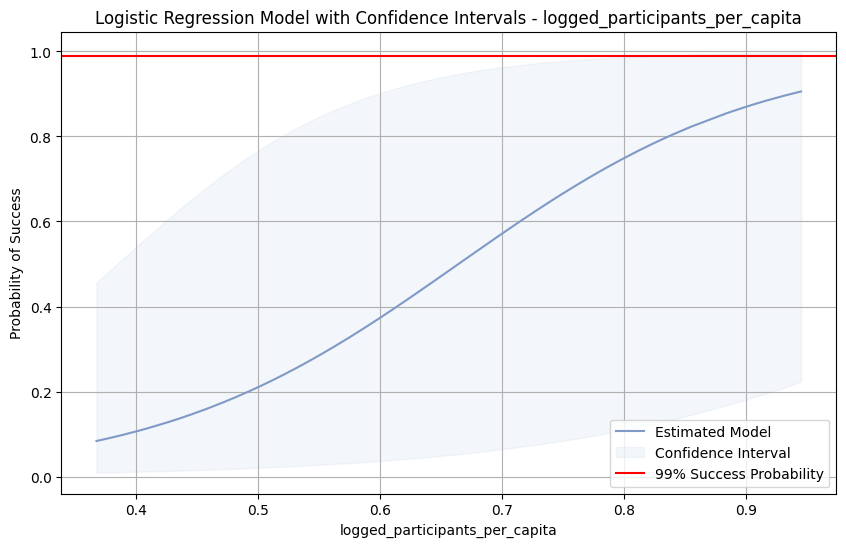

In [43]:
def plot_logistic_regression_results(x_data, y_estimated, y_ci_lower, y_ci_upper, predictor):
    plt.figure(figsize=(10, 6))
    plt.plot(x_data, y_estimated, label='Estimated Model', color='#7F9AC6')
    plt.fill_between(x_data, y_ci_lower, y_ci_upper, color='#DAE2EF', alpha=0.3, label='Confidence Interval')
    plt.axhline(y=0.99, color='red', linestyle='-', label='99% Success Probability')

    plt.xlabel(predictor)
    plt.ylabel('Probability of Success')
    plt.title(f'Logistic Regression Model with Confidence Intervals - {predictor}')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_logistic_regression_results(x_data, y_estimated, y_ci_lower, y_ci_upper, 'logged_participants_per_capita')

By extrapolating this upper bound, we identify the level of participation that aligns with a 99% success probability, a figure beyond the direct observations of our dataset. 
However, the implementation above only yields the log ratio of participation to population. To translate this into the actual percentage of population participation, the `find_tipping_point_and_percentage` function finds the row corresponding to the predicted success rate of 99%. It then retrieves the `percentage of population participation` for this specific data point, effectively bridging the gap between our statistical model and the practical insights we seek, grounded in Chenoweth's 3.5% rule.

In [44]:
def find_tipping_point_and_percentage(data, logistic_regression_result):
    # Extract coefficients and their confidence intervals
    params = logistic_regression_result.params
    conf_int = logistic_regression_result.conf_int()

    # Extracting intercept and coefficient
    intercept = params['const']
    coef = params['logged_participants_per_capita']
    
    # Extracting confidence intervals
    ci_intercept_low, ci_intercept_high = conf_int.loc['const']
    ci_coef_low, ci_coef_high = conf_int.loc['logged_participants_per_capita']

    # Sorting data
    sorted_data = data.sort_values(by='logged_participants_per_capita')
    x_data = sorted_data['logged_participants_per_capita']

    # Estimating probabilities and confidence intervals
    y_estimated = expit(intercept + coef * x_data)
    y_ci_lower = expit(ci_intercept_low + ci_coef_low * x_data)
    y_ci_upper = expit(ci_intercept_high + ci_coef_high * x_data)

    # Finding the tipping point
    threshold = 0.99
    tipping_points = {
        'Model': next((x for x, y in zip(x_data, y_estimated) if y > threshold), None),
        'Lower CI': next((x for x, y in zip(x_data, y_ci_lower) if y > threshold), None),
        'Upper CI': next((x for x, y in zip(x_data, y_ci_upper) if y > threshold), None)
    }

    # Determining which function crosses the threshold first and its tipping point
    first_cross_value, first_cross_function = min((v, k) for k, v in tipping_points.items() if v is not None)

    # Finding the corresponding row and PERCENTAGEPOPULARPARTICIPATION value
    row = data[data['logged_participants_per_capita'] == first_cross_value]
    percentage_popular_participation = row['PERCENTAGEPOPULARPARTICIPATION'].iloc[0] if not row.empty else None

    return first_cross_value, first_cross_function, percentage_popular_participation

# Example usage:
tipping_point, function, percentage_participation = find_tipping_point_and_percentage(data_processed, logistic_regression_result)
print(f"Function that exceeds the 99% threshold: {function}")
print(f"The tipping point is at {tipping_point}")
print(f"Percentage participation at the tipping point: {percentage_participation}")

Function that exceeds the 99% threshold: Upper CI
The tipping point is at 0.8403388124273167
Percentage participation at the tipping point: 9.10684054256127


The function's results indicate that within the upper confidence interval (Upper CI), a logged participants per capita value of approximately `0.840` crosses the `99%` success threshold. 
This corresponds to a population participation rate of about `9.11%`, which is the tipping point where a campaign's probability of success reaches near certainty within our dataset.

## 5. Nonviolent Resistance and Target Regime Type

For this task, we will incorporate the Polity V dataset to control for the regime type when examining the significance of nonviolent resistance on campaign success.
So let's read the csv file derived form the xcel sheet provided and see what we are dealing with here.

In [45]:
file_path = 'polity_data.csv'
polity_data = pd.read_csv(file_path, delimiter=';')

polity_data

,p5,cyear,ccode,scode,country,year,flag,fragment,democ,autoc,polity,polity2,durable,xrreg,xrcomp,xropen,xconst,parreg,parcomp,exrec,exconst,polcomp,prior,emonth,eday,eyear,eprec,interim,bmonth,bday,byear,bprec,post,change,d5,sf,regtrans
0,0,7001800,700,AFG,Afghanistan,1800,0,NaN,1,7,-6,-6.0,NaN,3,1,1,1,3,3,1.0,1,6.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1800.0,1.0,-6.0,88.0,1.0,NaN,NaN
1,0,7001801,700,AFG,Afghanistan,1801,0,NaN,1,7,-6,-6.0,NaN,3,1,1,1,3,3,1.0,1,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,7001802,700,AFG,Afghanistan,1802,0,NaN,1,7,-6,-6.0,NaN,3,1,1,1,3,3,1.0,1,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,7001803,700,AFG,Afghanistan,1803,0,NaN,1,7,-6,-6.0,NaN,3,1,1,1,3,3,1.0,1,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,7001804,700,AFG,Afghanistan,1804,0,NaN,1,7,-6,-6.0,NaN,3,1,1,1,3,3,1.0,1,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17569,1,5522014,552,ZIM,Zimbabwe,2014,0,0.0,5,1,4,4.0,1.0,2,2,4,5,3,3,7.0,5,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17570,1,5522015,552,ZIM,Zimbabwe,2015,0,0.0,5,1,4,4.0,2.0,2,2,4,5,3,3,7.0,5,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17571,1,5522016,552,ZIM,Zimbabwe,2016,0,0.0,5,1,4,4.0,3.0,2,2,4,5,3,3,7.0,5,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17572,1,5522017,552,ZIM,Zimbabwe,2017,0,0.0,5,1,4,4.0,4.0,2,2,4,5,3,3,7.0,5,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Specifically we will focus on the following columns:

* Country: Identifies the country in which the campaign is taking place.

* Year: The year when the campaign ends, which we'll use to match with the corresponding Polity V score.

* Democ (Democracy score): Reflects the democratic characteristics of the political regime.

* Autoc (Autocracy score): Measures the autocratic dimensions of the regime.

* Polity: The combined score derived from the Democracy and Autocracy scores.

* Polity2: An adjusted version of the Polity score, which is recommended for use in statistical models as it avoids special codes that denote periods of transition or anocracy, such as -66, -77, or -88, which could disrupt a regression analysis

The Polity2 score ranges from `-10 (full autocracy)` to `+10 (full democracy)`, representing a `21-point` scale that provides a nuanced gauge of regime characteristics for each country-year unit. 
In our logistic regression, controlling for the Polity V score of the campaign target will allow us to account for the type of regime against which the campaign was conducted, thus refining our understanding of the factors that contribute to a campaign's success.

The merge process aligns NAVCO's campaign data with Polity's regime scores by matching campaign locations and years. 
It selects key variables like `nonviolence` indicators, `Polity2` scores, and `participation` levels for the regression, and computes the `log of participation` for the regression, which we currently don't have in out dataframe. 
This prepares a cohesive dataset that combines campaign specifics with political context.

In [46]:
def merge_and_prepare_data(navco_data, polity_data):
    # Adjusting the Polity data's 'country' column to match the 'LOCATION' column format in NAVCO data
    polity_data['country'] = polity_data['country'].str.strip()  # Removing any leading/trailing whitespaces

    # Merging the datasets on 'LOCATION'/'country' and 'EYEAR'/'year'
    merged_data = pd.merge(navco_data, polity_data, left_on=['LOCATION', 'EYEAR'], right_on=['country', 'year'])
    
    # Selecting the relevant columns for logistic regression
    regression_columns = ['NONVIOL', 'polity2', 'PARTICIPATION', 'logged_population', 'SUCCESS_BINARY']

    # Adding a column for the log of participation
    merged_data['logged_participation'] = np.log(merged_data['PARTICIPATION'].replace(0, np.nan))
    
    regression_data = merged_data[regression_columns + ['logged_participation']].dropna()
    
    return regression_data

regression_data = merge_and_prepare_data(data_processed, polity_data)
regression_data

,NONVIOL,polity2,PARTICIPATION,logged_population,SUCCESS_BINARY,logged_participation
1,0,-8.0,10000,16.496532,1,9.210340
2,0,-7.0,20000,16.924572,1,9.903488
3,0,-1.0,60000,17.424293,0,11.002100
4,1,3.0,300000,15.007682,1,12.611538
5,0,-8.0,39000,16.213406,1,10.571317
...,...,...,...,...,...,...
300,1,-6.0,10000,16.176365,0,9.210340
301,0,-5.0,12500,16.166886,1,9.433484
302,1,6.0,23000,15.924478,1,10.043249
303,1,5.0,3000,16.197288,1,8.006368


With our data merged and prepared, we proceed to run the logistic regression. The independent variables included are `NONVIOL` (nonviolence indicator), `polity2` (regime type score), `logged_participation`, and `logged_population`. 
This model will allow us to assess the influence of these factors on the likelihood of campaign success, providing a comprehensive understanding of how nonviolent resistance interacts with political contexts and participation levels. 
The summary of the logistic regression will reveal the statistical significance and impact of each variable.

In [47]:
x_columns = ['NONVIOL', 'polity2', 'logged_participation', 'logged_population']
logistic_regression = train_model(regression_data, x_columns)
logistic_regression.summary()

Optimization terminated successfully.
         Current function value: 0.536938
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:         SUCCESS_BINARY   No. Observations:                  297
Model:                          Logit   Df Residuals:                      292
Method:                           MLE   Df Model:                            4
Date:                Mon, 04 Dec 2023   Pseudo R-squ.:                  0.2025
Time:                        22:14:08   Log-Likelihood:                -159.47
converged:                       True   LL-Null:                       -199.97
Covariance Type:            nonrobust   LLR p-value:                 1.075e-16
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    1.8727      1.498      1.250      0.211      -1.063       4.809
NONVIOL                  0.8662      0.295      2.936      0.003       0.288       1.445
polity2                  0.0522      0.025      2.057      0.040       0.002       0.102
logged_participation     0.4367      0.090      4.849      0.000       0.260       0.613
logged_population       -0.4270      0.099     -4.321      0.000      -0.621      -0.233
========================================================================================
"""

<span style="font-size:20px;"><strong>Description Summary</strong></span>
The logistic regression results provide valuable insights:

- **Pseudo R-squared (0.2025)**: Indicates a good fit, explaining about 20% of the variance in campaign success.
- **NONVIOL (0.8662; p=0.003)**: Nonviolent campaigns significantly increase the likelihood of success.
- **polity2 (0.0522; p=0.040)**: Suggests a positive, though moderate, impact of democratic regime types on campaign success.
- **logged_participation (0.4367; p<0.001)**: Higher participation increases success chances
- **logged_population (-0.4270; p<0.001)**: Larger population sizes slightly decrease it.

The functions conducts a logistic regression to evaluate nonviolent campaign success across different political regimes, categorized by the `categorize_polity` function using Polity2 scores. 
Predictions are visualized with a Seaborn pointplot, which distinguishes between regime types and marks campaign outcomes with color-coded points. 
This plot not only presents predicted probabilities but also incorporates error bars, indicating the confidence interval range for each point, thereby encapsulating the prediction's reliability across regime types.

/var/folders/3c/ltvq2skx5zs62xwpyp1933xm0000gq/T/ipykernel_69046/521029716.py:31: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0.

  sns.pointplot(data=regression_data, x='regime_type', y='predicted_probability', hue='NONVIOL',


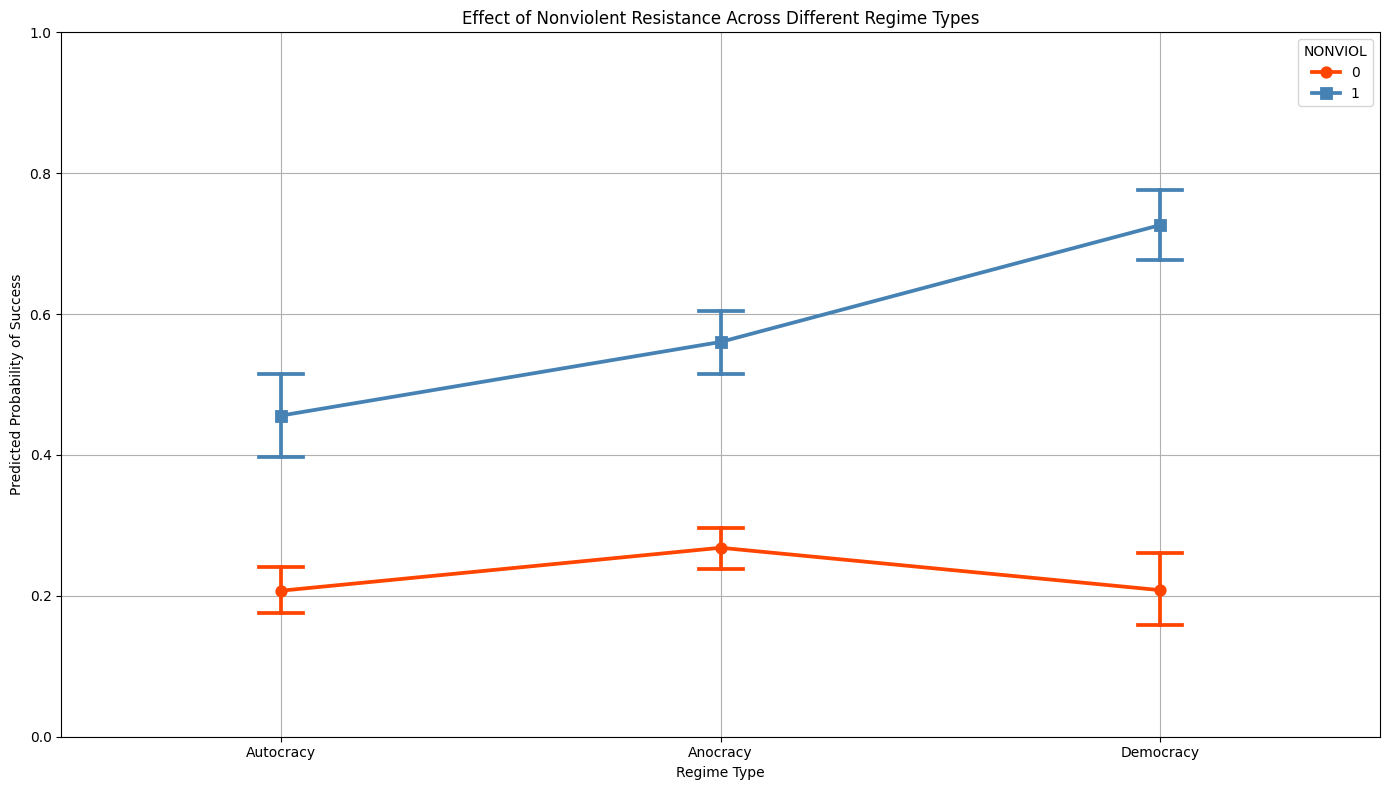

In [48]:
# Function to categorize Polity scores
def categorize_polity(polity_score):
    if polity_score <= -6:
        return 'Autocracy'
    elif polity_score <= 5:
        return 'Anocracy'
    else:
        return 'Democracy'

# Prepare the data for prediction
def prepare_data_for_prediction(data):
    X = data[['NONVIOL', 'polity2', 'logged_participation', 'logged_population']]
    X = sm.add_constant(X)  # Adding a constant term to the predictors
    return X

# Apply the categorization function to the Polity scores
regression_data['regime_type'] = regression_data['polity2'].apply(categorize_polity)

# Prepare the data for prediction
X_pred = prepare_data_for_prediction(regression_data)

# Use the fitted model to make predictions on the prepared data
regression_data['predicted_probability'] = logistic_regression.predict(X_pred)

custom_palette = {0: '#FF4500',  # red for violent
                  1: '#4682B4'}  # blue for nonviolent


# Plotting with adjustments
plt.figure(figsize=(14, 8))  # Adjust the figure size
sns.pointplot(data=regression_data, x='regime_type', y='predicted_probability', hue='NONVIOL',
              order=['Autocracy', 'Anocracy', 'Democracy'], dodge=0,  # Increase dodge to separate the points
              join=True,
              markers=['o', 's'], capsize=.1, 
              palette=custom_palette)

plt.title('Effect of Nonviolent Resistance Across Different Regime Types')
plt.ylabel('Predicted Probability of Success')
plt.xlabel('Regime Type')
plt.ylim(0, 1)
plt.legend(title='NONVIOL')
plt.grid(True)
plt.tight_layout()  # Adjust layout to fit the figure and prevent clipping of titles/labels
plt.show()

The results demonstrate that nonviolent campaigns generally exhibit a higher predicted success probability compared to violent ones across all regime types. 
Notably, within democratic regimes, violent campaigns experience a significant decline in success probability, highlighting the unique challenges they face within democratic contexts. 
Conversely, nonviolent campaigns in democracies achieve approximately an 80% success rate, significantly outperforming autocracies and anocracies. This underscores the enduring significance of nonviolent strategies in predicting campaign success. 

Now if we would like to examine how the other independent variables infuence the probability of a successfull campgaign, we can showcase the effect they have using the following functions.

The `plot_effect_of_logged_participation` function generates a predictive curve of success probability against logged participation in resistances. It creates hypothetical scenarios by varying logged participation, using `linspace` from the min to max value of the `logged_participation` column, while holding other variables constant at their mean values. The function concludes with a visual representation of the relationship via a line plot.

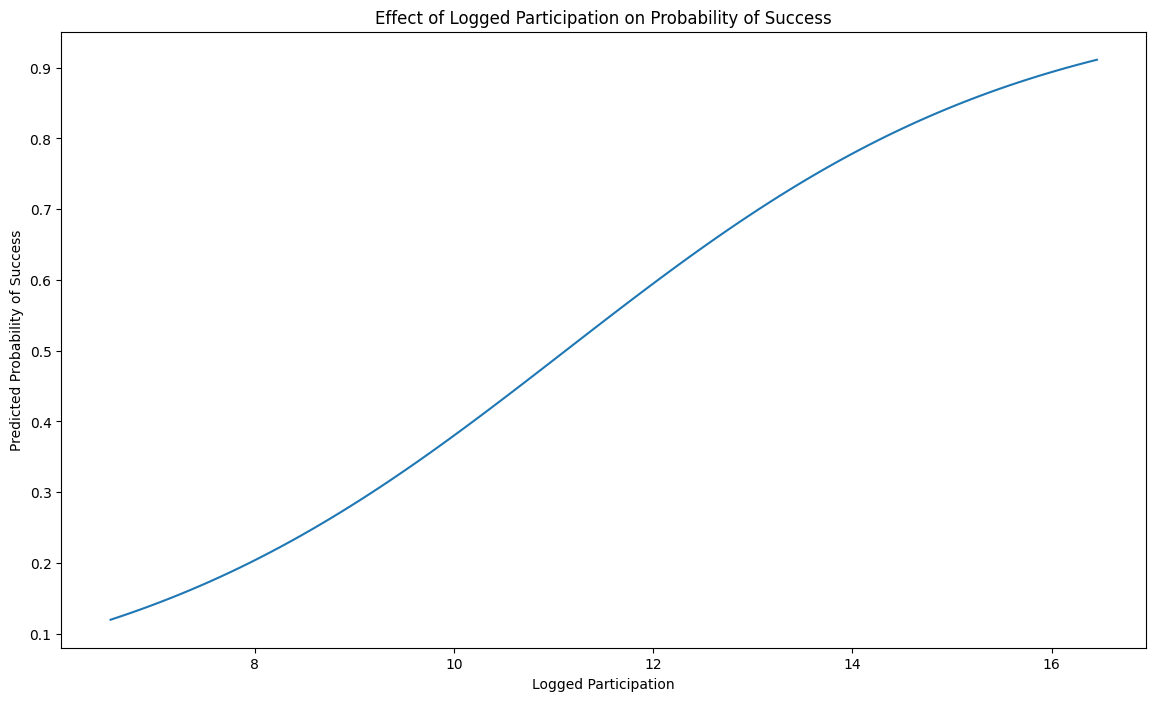

In [49]:
def plot_effect_of_logged_participation(regression_data, logistic_regression):
    # Generate a range of values for logged_participation
    logged_participation_values = np.linspace(regression_data['logged_participation'].min(), 
                                              regression_data['logged_participation'].max(), 100)

    # Set other variables to their mean values
    mean_values = regression_data[['NONVIOL', 'polity2', 'logged_population']].mean()

    # Repeat mean values for each entry in logged_participation_values
    repeated_mean_values = np.repeat(mean_values.values.reshape(1, -1), len(logged_participation_values), axis=0)

    # Correctly align the variables as per the model's structure
    # Ensure that the order of variables matches the order in which the model was trained
    X = np.column_stack([np.ones(len(logged_participation_values)), 
                         repeated_mean_values[:, 0],  # NONVIOL
                         repeated_mean_values[:, 1],  # polity2
                         logged_participation_values, # logged_participation
                         repeated_mean_values[:, 2]]) # logged_population

    # Predict probabilities for these scenarios
    predicted_probabilities = logistic_regression.predict(X)

    # Plotting
    plt.figure(figsize=(14, 8))
    sns.lineplot(x=logged_participation_values, y=predicted_probabilities)
    plt.title('Effect of Logged Participation on Probability of Success')
    plt.xlabel('Logged Participation')
    plt.ylabel('Predicted Probability of Success')
    plt.show()

plot_effect_of_logged_participation(regression_data, logistic_regression)

The plot implies a positive correlation between logged participation and success probability campaigns. This underscores the "power in numbers" axiom, suggesting larger mobilizations increase the chances of achieving campaign goals.

Finally the influence of population size on the success probability of campaigns, can be explained using the `plot_effect_of_logged_population` function. It predicts outcomes based on a range of population values, using the same logic of linspace as before, while maintaining other variables at their mean. The output is a declining line plot, indicating the relationship.

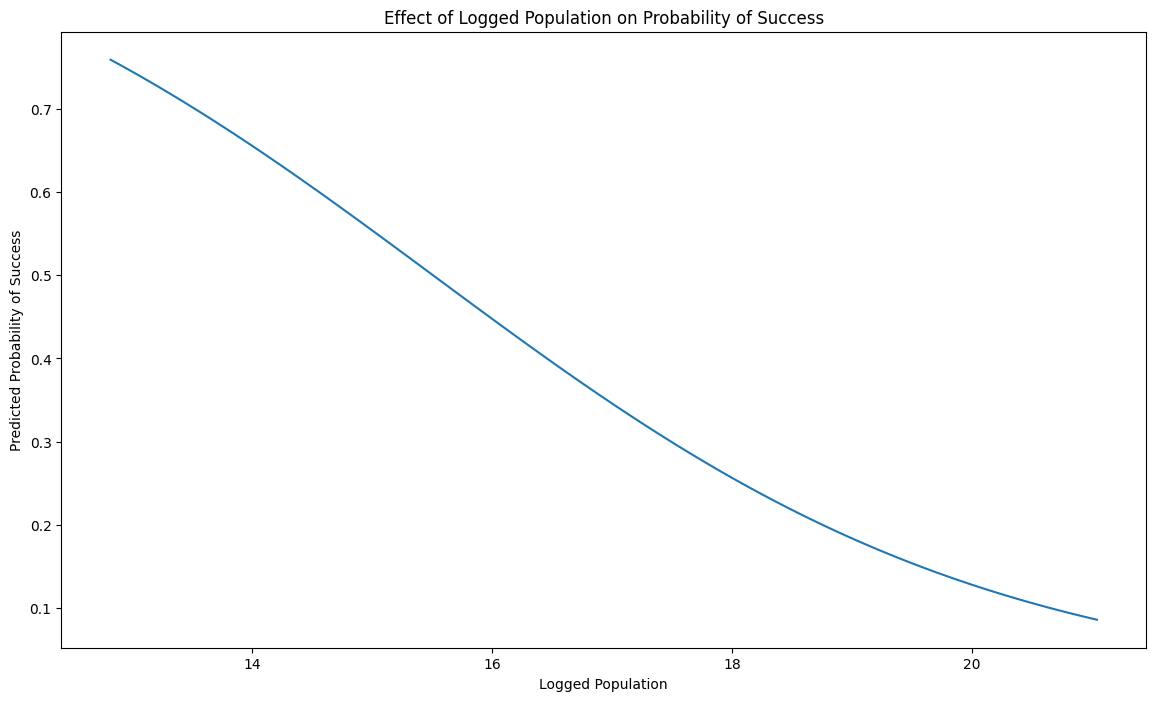

In [50]:
def plot_effect_of_logged_population(regression_data, logistic_regression):
    # Generate a range of values for logged_population
    logged_population_values = np.linspace(regression_data['logged_population'].min(), 
                                           regression_data['logged_population'].max(), 100)

    # Set other variables to their mean values
    mean_values = regression_data[['NONVIOL', 'polity2', 'logged_participation']].mean()

    # Repeat mean values for each entry in logged_population_values
    repeated_mean_values = np.repeat(mean_values.values.reshape(1, -1), len(logged_population_values), axis=0)

    # Correctly align the variables as per the model's structure
    X = np.column_stack([np.ones(len(logged_population_values)), 
                         repeated_mean_values[:, 0],  # NONVIOL
                         repeated_mean_values[:, 1],  # polity2
                         repeated_mean_values[:, 2],  # logged_participation
                         logged_population_values])   # logged_population

    # Predict probabilities for these scenarios
    predicted_probabilities = logistic_regression.predict(X)

    # Plotting
    plt.figure(figsize=(14, 8))
    sns.lineplot(x=logged_population_values, y=predicted_probabilities)
    plt.title('Effect of Logged Population on Probability of Success')
    plt.xlabel('Logged Population')
    plt.ylabel('Predicted Probability of Success')
    plt.show()

# Call the function with the regression_data and logistic_regression model
plot_effect_of_logged_population(regression_data, logistic_regression)

The generated plot suggests a negative association between the size of the population and the likelihood resistance success. It implies that larger populations may present more complex challenges for organizing effective resistance campaigns.